In [ ]:
# ==========================================================
# 1️⃣ IMPORT LIBRARIES
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# ================================
# 2️ LOAD DATASETS
# ================================

# Load review dataset
reviews = pd.read_csv('/content/Zomato Restaurant reviews.csv')

# Load metadata dataset (optional for extension)
metadata = pd.read_csv('/content/Zomato Restaurant names and Metadata.csv')

print("Reviews Dataset Shape:", reviews.shape)
print("Metadata Dataset Shape:", metadata.shape)

print("\nFirst 5 rows of Reviews Dataset:")
print(reviews.head())

Reviews Dataset Shape: (10000, 7)
Metadata Dataset Shape: (105, 6)

First 5 rows of Reviews Dataset:
        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54         0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0  
3    1 Review , 1 Follower  5/2

In [ ]:
# ================================
# 3️ DATA UNDERSTANDING & CLEANING
# ================================

# Check for missing values
print("\nMissing Values:")
print(reviews.isnull().sum())

# Drop missing reviews if any
reviews = reviews.dropna(subset=['Review', 'Rating'])


Missing Values:
Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64


In [ ]:
# =====================================
# FIX RATING COLUMN (IMPORTANT STEP)
# =====================================

# Convert to string first (safe step)
reviews['Rating'] = reviews['Rating'].astype(str)

# Extract only numeric part (handles 4, 4.0, 4.5/5, Rated 4.0 etc.)
reviews['Rating'] = reviews['Rating'].str.extract('(\d+\.?\d*)')

# Convert to numeric
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')

# Remove rows where rating could not be converted
reviews = reviews.dropna(subset=['Rating'])

print("Rating datatype after cleaning:", reviews['Rating'].dtype)


Rating datatype after cleaning: float64


<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2435598800.py:9: SyntaxWarning: invalid escape sequence '\d'
  reviews['Rating'] = reviews['Rating'].str.extract('(\d+\.?\d*)')


In [ ]:
# ================================
# CREATE SENTIMENT COLUMN
# ================================

def get_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating >= 3:
        return 'Neutral'
    else:
        return 'Negative'

reviews['Sentiment'] = reviews['Rating'].apply(get_sentiment)

print("\nSentiment Distribution:")
print(reviews['Sentiment'].value_counts())



Sentiment Distribution:
Sentiment
Positive    6268
Negative    2447
Neutral     1239
Name: count, dtype: int64


In [ ]:
# ================================
# 5️ TEXT PREPROCESSING (NLP)
# ================================

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove numbers
    4. Remove punctuation
    5. Remove stopwords
    6. Apply lemmatization
    """
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(words)
# Apply cleaning
reviews['Clean_Review'] = reviews['Review'].apply(clean_text)

print("\nSample Cleaned Review:")
print(reviews['Clean_Review'].iloc[0])


Sample Cleaned Review:
ambience good food quite good saturday lunch cost effective good place sate brunch one also chill friend parent waiter soumen da really courteous helpful


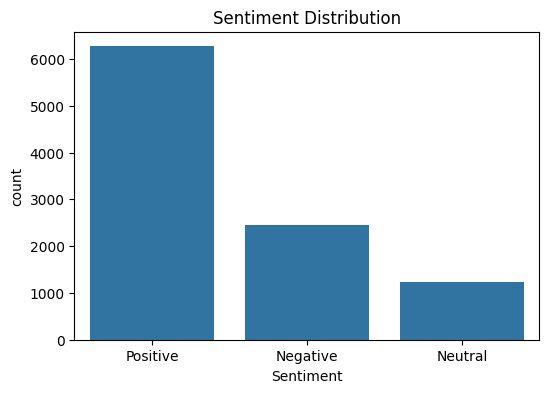

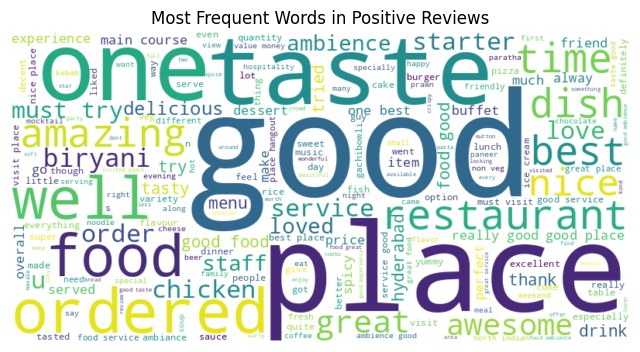

In [ ]:
# ================================
# 6️ EXPLORATORY DATA ANALYSIS
# ================================

# Sentiment Count Plot
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=reviews)
plt.title("Sentiment Distribution")
plt.show()

# WordCloud for Positive Reviews
positive_text = " ".join(reviews[reviews['Sentiment']=='Positive']['Clean_Review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Positive Reviews")
plt.show()

In [ ]:
# ================================
# 7️ FEATURE ENGINEERING (TF-IDF)
# ================================

tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(reviews['Clean_Review'])
y = reviews['Sentiment']

print("\nTF-IDF Feature Matrix Shape:", X.shape)


TF-IDF Feature Matrix Shape: (9954, 5000)


In [ ]:
# ================================
# 8️ TRAIN-TEST SPLIT
# ================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# ================================
# 9️ MODEL BUILDING
# ================================

# 🔹 Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

print("\n--- Logistic Regression Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# 🔹 Model 2: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("\n--- Naive Bayes Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


--- Logistic Regression Results ---
Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80       501
     Neutral       0.47      0.18      0.26       240
    Positive       0.84      0.95      0.89      1250

    accuracy                           0.82      1991
   macro avg       0.71      0.64      0.65      1991
weighted avg       0.79      0.82      0.79      1991


--- Naive Bayes Results ---
Accuracy: 0.7885484681064792
              precision    recall  f1-score   support

    Negative       0.89      0.66      0.76       501
     Neutral       0.50      0.00      0.01       240
    Positive       0.77      0.99      0.86      1250

    accuracy                           0.79      1991
   macro avg       0.72      0.55      0.54      1991
weighted avg       0.76      0.79      0.73      1991



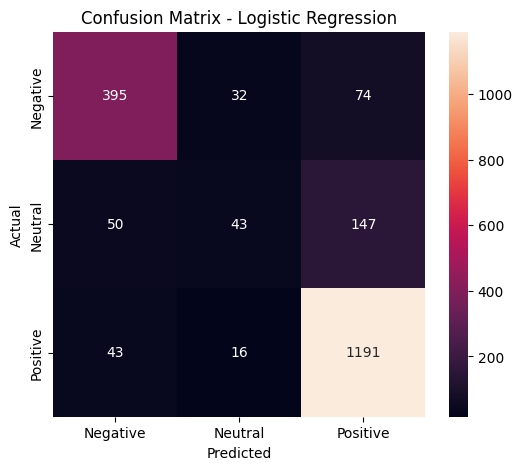

In [ ]:
# ================================
# 10 CONFUSION MATRIX (BEST MODEL)
# ================================

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


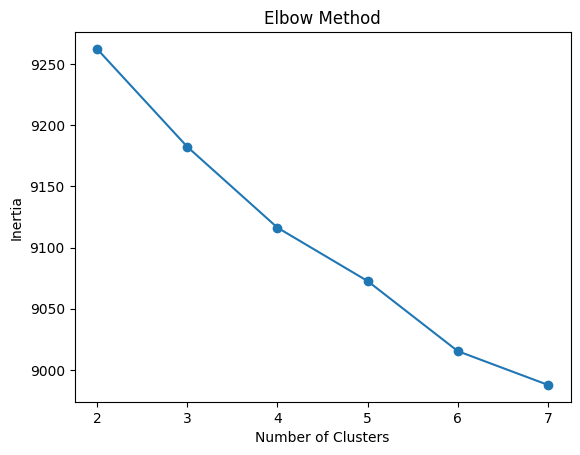

In [ ]:
# ==========================================================
# 1️⃣2️⃣ CLUSTERING - ELBOW METHOD
# ==========================================================

inertia = []
K = range(2,8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# ==========================================================
# 1️⃣3️⃣ FINAL KMEANS (K=3)
# ==========================================================

kmeans = KMeans(n_clusters=3, random_state=42)
reviews['Cluster'] = kmeans.fit_predict(X)

print("\nCluster Distribution:")
print(reviews['Cluster'].value_counts())


Cluster Distribution:
Cluster
0    9328
1     424
2     202
Name: count, dtype: int64


In [ ]:
# ==========================================================
# 1️⃣4️⃣ SILHOUETTE SCORE
# ==========================================================

score = silhouette_score(X, reviews['Cluster'])
print("\nSilhouette Score:", score)


Silhouette Score: 0.024861244754891237


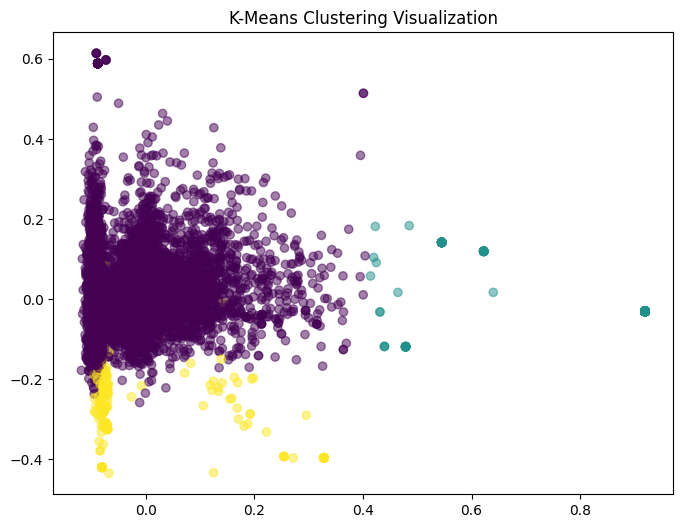

In [ ]:
# ==========================================================
# 1️⃣5️⃣ PCA VISUALIZATION
# ==========================================================

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1],
            c=reviews['Cluster'], cmap='viridis', alpha=0.5)
plt.title("K-Means Clustering Visualization")
plt.show()

In [ ]:
# ================================
# 1️1️ PREDICTION FUNCTION (DEPLOYMENT READY)
# ================================

def predict_sentiment(review_text):
    """
    This function takes a new review as input
    and predicts whether it is Positive, Neutral or Negative.
    """
    cleaned = clean_text(review_text)
    vector = tfidf.transform([cleaned])
    prediction = lr_model.predict(vector)
    return prediction[0]

# Example Prediction
example_review = "The food was amazing and service was excellent!"
print("\nExample Prediction:")
print("Review:", example_review)
print("Predicted Sentiment:", predict_sentiment(example_review))


Example Prediction:
Review: The food was amazing and service was excellent!
Predicted Sentiment: Positive
